# Microsoft Studios Preliminary Analysis

### A temporal and fiscal examination

#### Harrison Carter
#### Joseph Mata
#### 2022-06-02
#### NYC-DS-051622

## Overview

The hypothetical Microsoft Studios is starting their streaming platform and looking for any advice they can get. This project uses datasets gathered in 2019 from four different online databases to make specific reccomendations for the upcoming platform and their future endeavors in film.

In [2]:
#import relevant modules
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import seaborn as sns
import numpy as np
import datetime
import warnings

In [3]:
# Disable pandas warnings for readability
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# gather datasets
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

# connect to SQL and save dataframe
conn = sqlite3.connect('zippedData/im.db')
imdb = pd.read_sql('''
    SELECT *
    FROM movie_basics; 
    ''',conn)

tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')

tn = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [5]:
# merge datasets
bi = bom.merge(imdb, how='inner', left_on = 'title', right_on = 'original_title')
bit = bi.merge(tmdb, how='inner', left_on='title', right_on='title')
bitt = bit.merge(tn, how='inner', left_on='original_title_x', right_on='movie')

In [6]:
#Drop duplicates
bit = bit.drop_duplicates(['primary_title'])
bitt = bitt.drop_duplicates(['primary_title'])

In [7]:
# remove unwanted characters
bitt['foreign_gross'] = bitt['foreign_gross'].str.replace(',', '')
bitt['foreign_gross'] = bitt['foreign_gross'].str.replace('$', '')
bitt['foreign_gross'] = bitt['foreign_gross'].astype(float)
bitt['worldwide_gross'] = bitt['worldwide_gross'].str.replace('$', '')
bitt['worldwide_gross'] = bitt['worldwide_gross'].str.replace(',', '')
bitt['worldwide_gross'] = bitt['worldwide_gross'].astype(float)
bitt['production_budget'] = bitt['production_budget'].str.replace('$', '')
bitt['production_budget'] = bitt['production_budget'].str.replace(',', '')
bitt['production_budget'] = bitt['production_budget'].astype(float)

Now that the data sets are imported and cleaned, lets inspect the first five elements and the DataFrame information. We see that the merges produced extra columns where redundant column names needed to be differentiated. Many of these can be ignored for our purposes. Looking closer, we notice that the values in release_date_x and release_date_y do not match. Only one of these values can be correct, and a cursory internet search tells us that the release_date_y values are correct, so we will be using those values for release date considerations.

In [8]:
bitt.head()

,title,studio,domestic_gross_x,foreign_gross,year,movie_id,primary_title,original_title_x,start_year,runtime_minutes,...,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross_y,worldwide_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,...,24.445,2010-06-17,7.7,8340,47,"Jun 18, 2010",Toy Story 3,200000000.0,"$415,004,880",1.068880e+09
1,Inception,WB,292600000.0,535700000.0,2010,tt1375666,Inception,Inception,2010,148.0,...,27.920,2010-07-16,8.3,22186,38,"Jul 16, 2010",Inception,160000000.0,"$292,576,195",8.355246e+08
2,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,tt0892791,Shrek Forever After,Shrek Forever After,2010,93.0,...,15.041,2010-05-16,6.1,3843,27,"May 21, 2010",Shrek Forever After,165000000.0,"$238,736,787",7.562447e+08
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000.0,2010,tt1325004,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,2010,124.0,...,20.340,2010-06-23,6.0,4909,53,"Jun 30, 2010",The Twilight Saga: Eclipse,68000000.0,"$300,531,751",7.061028e+08
4,Iron Man 2,Par.,312400000.0,311500000.0,2010,tt1228705,Iron Man 2,Iron Man 2,2010,124.0,...,28.515,2010-05-07,6.8,12368,15,"May 7, 2010",Iron Man 2,170000000.0,"$312,433,331",6.211564e+08


In [9]:
bitt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1143 entries, 0 to 1997
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1143 non-null   object 
 1   studio             1143 non-null   object 
 2   domestic_gross_x   1142 non-null   float64
 3   foreign_gross      996 non-null    float64
 4   year               1143 non-null   int64  
 5   movie_id           1143 non-null   object 
 6   primary_title      1143 non-null   object 
 7   original_title_x   1143 non-null   object 
 8   start_year         1143 non-null   int64  
 9   runtime_minutes    1122 non-null   float64
 10  genres             1138 non-null   object 
 11  Unnamed: 0         1143 non-null   int64  
 12  genre_ids          1143 non-null   object 
 13  id_x               1143 non-null   int64  
 14  original_language  1143 non-null   object 
 15  original_title_y   1143 non-null   object 
 16  popularity         1143 

What kind of movie should we make? Lets take a look at how much money the major genres typically make, and while we're at it, lets look at how much they cost.

In [10]:
# Find the average production budget and worldwide gross for each major genre
com = bitt[bitt['genres'].str.contains('Comedy')==True]
com_bud = com['production_budget'].mean()
com_g = com['worldwide_gross'].mean()

dra = bitt[bitt['genres'].str.contains('Drama')==True]
dra_bud = dra['production_budget'].mean()
dra_g = dra['worldwide_gross'].mean()

act = bitt[bitt['genres'].str.contains('Action')==True]
act_bud = act['production_budget'].mean()
act_g = act['worldwide_gross'].mean()

sci = bitt[bitt['genres'].str.contains('Sci')==True]
sci_bud = sci['production_budget'].mean()
sci_g = com['worldwide_gross'].mean()

ani = bitt[bitt['genres'].str.contains('Animation')==True]
ani_bud = ani['production_budget'].mean()
ani_g = ani['worldwide_gross'].mean()

rom = bitt[bitt['genres'].str.contains('Romance')==True]
rom_bud = rom['production_budget'].mean()
rom_g = rom['worldwide_gross'].mean()

doc = bitt[bitt['genres'].str.contains('Documentary')==True]
doc_bud = doc['production_budget'].mean()
doc_g = doc['worldwide_gross'].mean()

wes = bitt[bitt['genres'].str.contains('Western')==True]
wes_bud = wes['production_budget'].mean()
wes_g = wes['worldwide_gross'].mean()

hor = bitt[bitt['genres'].str.contains('Horror')==True]
hor_bud = hor['production_budget'].mean()
hor_g = hor['worldwide_gross'].mean()

adv = bitt[bitt['genres'].str.contains('Adventure')==True]
adv_bud = adv['production_budget'].mean()
adv_g = adv['worldwide_gross'].mean()

mys = bitt[bitt['genres'].str.contains('Mystery')==True]
mys_bud = mys['production_budget'].mean()
mys_g = mys['worldwide_gross'].mean()

# Initialize list of means of genres in question
gen = ['Comedy','Drama','Action','Sci-Fi','Animation','Romance','Documentary','Western','Horror','Adventure','Mystery']
gen_bud = [com_bud,dra_bud,act_bud,sci_bud,ani_bud,rom_bud,doc_bud,wes_bud,hor_bud,adv_bud,mys_bud]
gen_g = [com_g,dra_g,act_g,sci_g,ani_g,rom_g,doc_g,wes_g,hor_g,adv_g,mys_g]

In [11]:
# Create dataframe containing average budget and average worldwide gross per genre
genred = {'Genre':  gen,
        'Budget': gen_bud,
        'Worldwide Gross': gen_g}

gendf = pd.DataFrame(genred)

print (gendf)

          Genre        Budget  Worldwide Gross
0        Comedy  4.266369e+07     1.482201e+08
1         Drama  2.828507e+07     8.162471e+07
2        Action  8.643283e+07     2.672391e+08
3        Sci-Fi  9.780477e+07     1.482201e+08
4     Animation  1.029217e+08     3.942728e+08
5       Romance  2.176330e+07     7.090539e+07
6   Documentary  1.233333e+07     5.888093e+07
7       Western  6.243750e+07     1.232272e+08
8        Horror  2.055650e+07     8.425086e+07
9     Adventure  1.108069e+08     3.723460e+08
10      Mystery  2.627189e+07     1.027942e+08


In [12]:
# Melt dataframe to correct format for catplot
gendfm = pd.melt(gendf,id_vars='Genre')
gendfm

,Genre,variable,value
0,Comedy,Budget,4.266369e+07
1,Drama,Budget,2.828507e+07
2,Action,Budget,8.643283e+07
3,Sci-Fi,Budget,9.780477e+07
4,Animation,Budget,1.029217e+08
5,Romance,Budget,2.176330e+07
6,Documentary,Budget,1.233333e+07
7,Western,Budget,6.243750e+07
8,Horror,Budget,2.055650e+07
9,Adventure,Budget,1.108069e+08


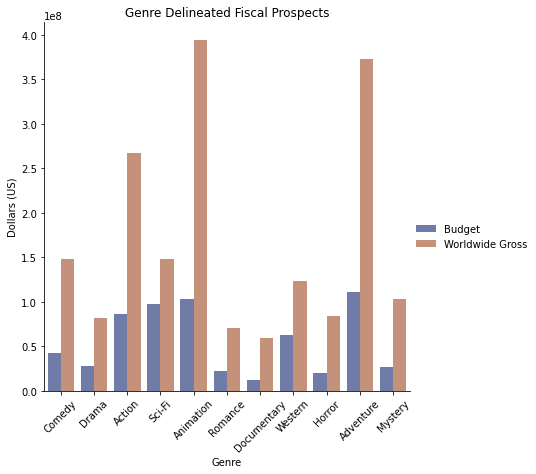

In [13]:
g = sns.catplot(
    data=gendfm, kind="bar",
    x="Genre", y="value", hue="variable",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.set_axis_labels("Genre", "Dollars (US)")
plt.xticks(rotation=45)
plt.title('Genre Delineated Fiscal Prospects')
g.legend.set_title("")

Clearly, animated films make far and away the most money on average compared to other genres. They also are on the more expensive side to make, but the profit margin is still visibly the largest of all categories. Looks like we have to spend money to make money, as per the saying.

Going forward, lets concentrate on animated films so our descriptive statistics best match the advisory in our conclusion.

In [14]:
#Isolate animated films
anima = bitt[bitt['genres'].str.contains('Animation')==True]

''

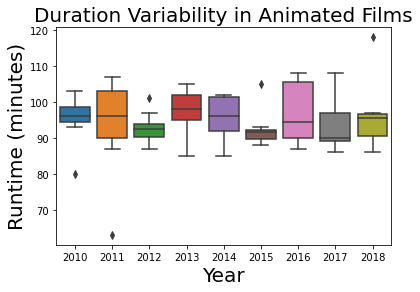

In [15]:
p = sns.boxplot(x=anima['start_year'],y=anima['runtime_minutes'])

plt.title('Duration Variability in Animated Films',fontsize=20)
p.set_xlabel('Year',fontsize=20)
p.set_ylabel('Runtime (minutes)',fontsize=20)
;

In [31]:
# Change release date to datetime format to work with month
anima['release_date_x'] = pd.to_datetime(anima['release_date_x'])

C:\Users\harri\AppData\Local\Temp\ipykernel_7312\3485826538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anima['release_date_x'] = pd.to_datetime(anima['release_date_x'])


In [19]:
# Isolate month
anima['month'] = anima['release_date_x'].dt.month

C:\Users\harri\AppData\Local\Temp\ipykernel_7312\2525340311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anima['month'] = anima['release_date_x'].dt.month


Here we determine the best month to release an animated film

C:\Users\harri\AppData\Local\Temp\ipykernel_7312\3990228335.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(months)


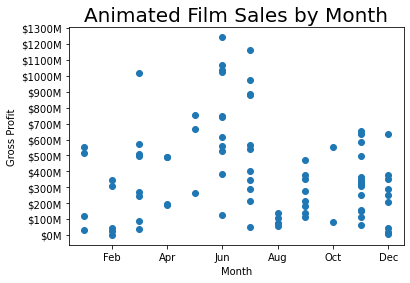

In [21]:
fig, ax = plt.subplots()
plt.scatter(anima['month'],anima['worldwide_gross'])
months = ['Jan', 'Feb', 'Apr', 'Jun',  'Aug', 'Oct', 'Dec', 'Jan']
ax.set_xticklabels(months)
ax.set_title('Animated Film Sales by Month', fontsize=20)
ax.set_xlabel('Month')
ax.set_ylabel('Gross Profit')
ax.set_yticks([x for x in np.arange(0,1400000000,100000000)])
ax.set_yticklabels(['$'+str(x)+'M' for x in np.arange(0,1400,100)]);

Here we determine the most profitable studio to hire

''

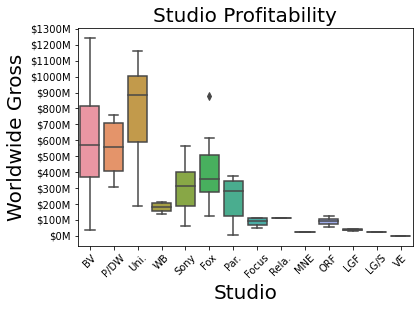

In [33]:
p = sns.boxplot(x=anima['studio'],y=anima['worldwide_gross'])

plt.title('Studio Profitability',fontsize=20)
p.set_xlabel('Studio',fontsize=20)
p.set_ylabel('Worldwide Gross',fontsize=20)
p.set_yticks([x for x in np.arange(0,1400000000,100000000)])
p.set_yticklabels(['$'+str(x)+'M' for x in np.arange(0,1400,100)])
plt.xticks(rotation=45)
;